In [1]:
from manifold_learning import IMD
from FastCCM import CCM
import numpy as np
from pydmd import DMD, BOPDMD
from manifold_learning.utils import utils
from sklearn.decomposition import PCA
from pydmd.preprocessing import zero_mean_preprocessing
from pydmd.plotter import plot_summary
from manifold_learning.data.data_loader import load_csv_dataset,get_truncated_lorenz_rand
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import imageio
import os
import tempfile
import importlib

In [19]:
X = load_csv_dataset("Jan1023_1_fr_ma2sec_sr30.csv").to_numpy()[:,1:]
observables = StandardScaler().fit_transform(X)

In [2]:
X = load_csv_dataset("Trace_Normo_Fish1_133105.csv").to_numpy()
pos = load_csv_dataset("spPosfiltered.csv").to_numpy()
y = X[200:,[-1]]
X =  X[200:,:-1]
#ppca = PCA(whiten=True)
#observables = ppca.fit_transform(X)
observables = X
observables = np.log((observables - observables.min() + 1e-1))

observables = StandardScaler().fit_transform(observables)

In [3]:
ppca = PCA(whiten=False)
observables = ppca.fit_transform(observables)

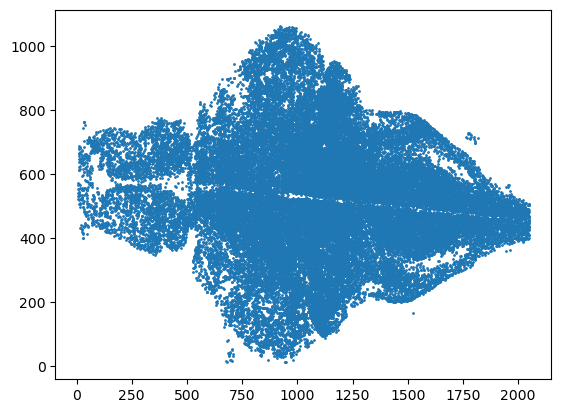

In [4]:
plt.scatter(pos[:,0],pos[:,1],s=1)

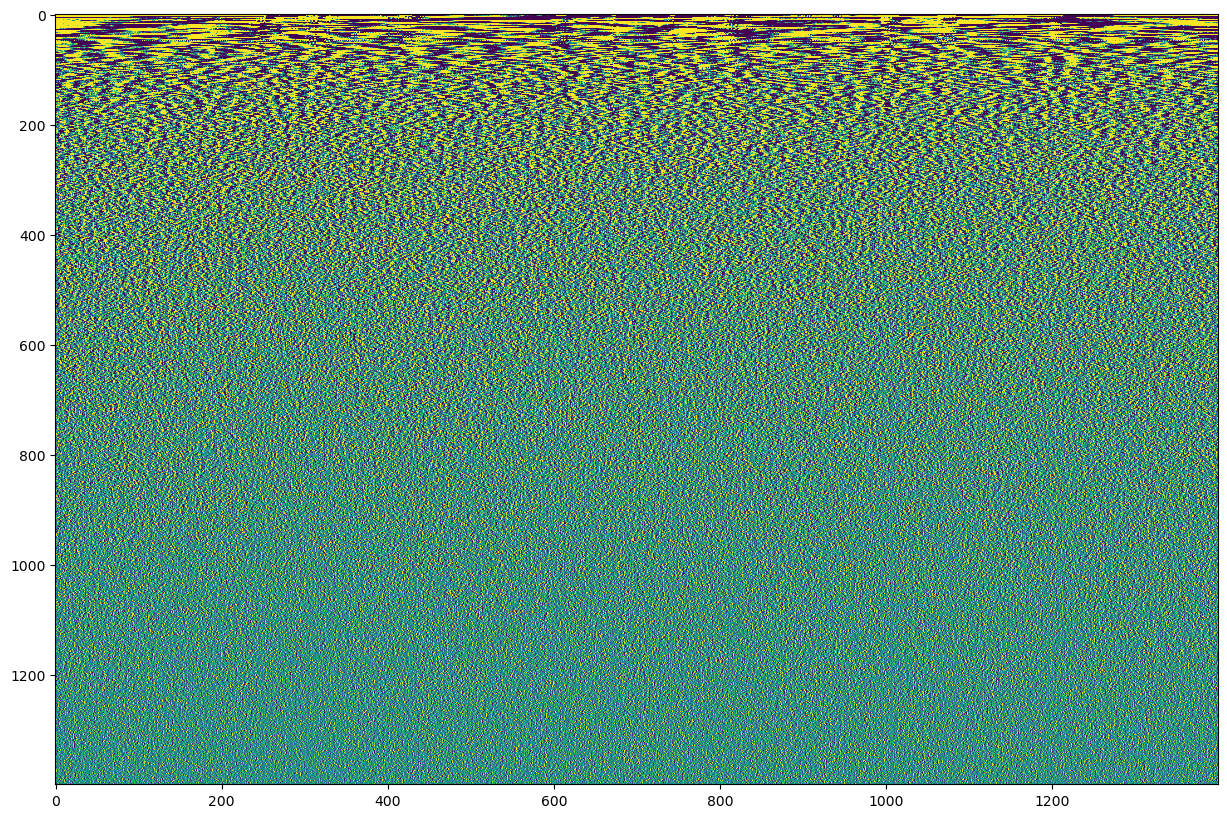

In [5]:
plt.figure(figsize=(15,10))
plt.imshow(observables.T,aspect="auto",vmin=-3,vmax=3)

In [ ]:
observables = utils.get_td_embedding_np(observables,5,20).reshape(-1,5*observables.shape[1])


In [6]:
trainer = IMD.IMD_nD(observables.shape[1], embed_dim=5, n_components=5,subtract_corr=True, device="cuda")

In [8]:
trainer = IMD.IMD_nD_smap(observables.shape[1], embed_dim=5, n_components=6, subtract_corr=True, device="cuda")


In [10]:
trainer.fit(observables, sample_len=150, library_len=800, 
            exclusion_rad=30, theta=5, tp=60, 
            epochs=1000, num_batches=32, optimizer="Adam", learning_rate=0.1, tp_policy="range")


Epoch 1/1000, Loss: 1.0962
Epoch 2/1000, Loss: 1.0882
Epoch 3/1000, Loss: 1.0828
Epoch 4/1000, Loss: 1.0795
Epoch 5/1000, Loss: 1.0761
Epoch 6/1000, Loss: 1.0729
Epoch 7/1000, Loss: 1.0696
Epoch 8/1000, Loss: 1.0678
Epoch 9/1000, Loss: 1.0666
Epoch 10/1000, Loss: 1.0628
Epoch 11/1000, Loss: 1.0601
Epoch 12/1000, Loss: 1.0583
Epoch 13/1000, Loss: 1.0564
Epoch 14/1000, Loss: 1.0558
Epoch 15/1000, Loss: 1.0516
Epoch 16/1000, Loss: 1.0502
Epoch 17/1000, Loss: 1.0476
Epoch 18/1000, Loss: 1.0456
Epoch 19/1000, Loss: 1.0403
Epoch 20/1000, Loss: 1.0388
Epoch 21/1000, Loss: 1.0356
Epoch 22/1000, Loss: 1.0310
Epoch 23/1000, Loss: 1.0281
Epoch 24/1000, Loss: 1.0281
Epoch 25/1000, Loss: 1.0230
Epoch 26/1000, Loss: 1.0188
Epoch 27/1000, Loss: 1.0137
Epoch 28/1000, Loss: 1.0084
Epoch 29/1000, Loss: 1.0080
Epoch 30/1000, Loss: 1.0027
Epoch 31/1000, Loss: 0.9992
Epoch 32/1000, Loss: 0.9915
Epoch 33/1000, Loss: 0.9895
Epoch 34/1000, Loss: 0.9817
Epoch 35/1000, Loss: 0.9788
Epoch 36/1000, Loss: 0.9725
E

In [60]:
trainer.fit(observables, sample_len=600, library_len=2000, 
            exclusion_rad=30, nbrs_num=30, tp=60, 
            epochs=1500, num_batches=1,optimizer="RMSprop", learning_rate=0.0003,tp_policy="range")


TypeError: IMD_nD_smap.fit() got an unexpected keyword argument 'nbrs_num'

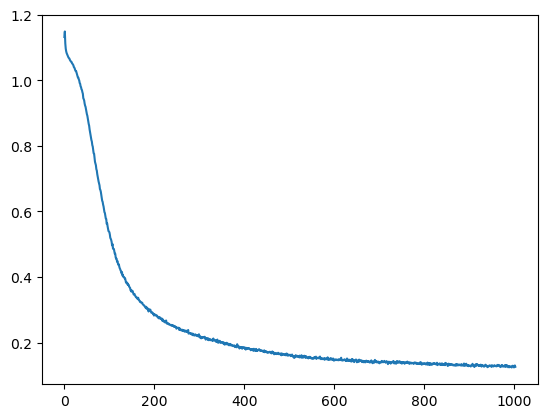

In [11]:
plt.plot(trainer.get_loss_history()[:])


In [12]:

unmixed = trainer.predict(observables)

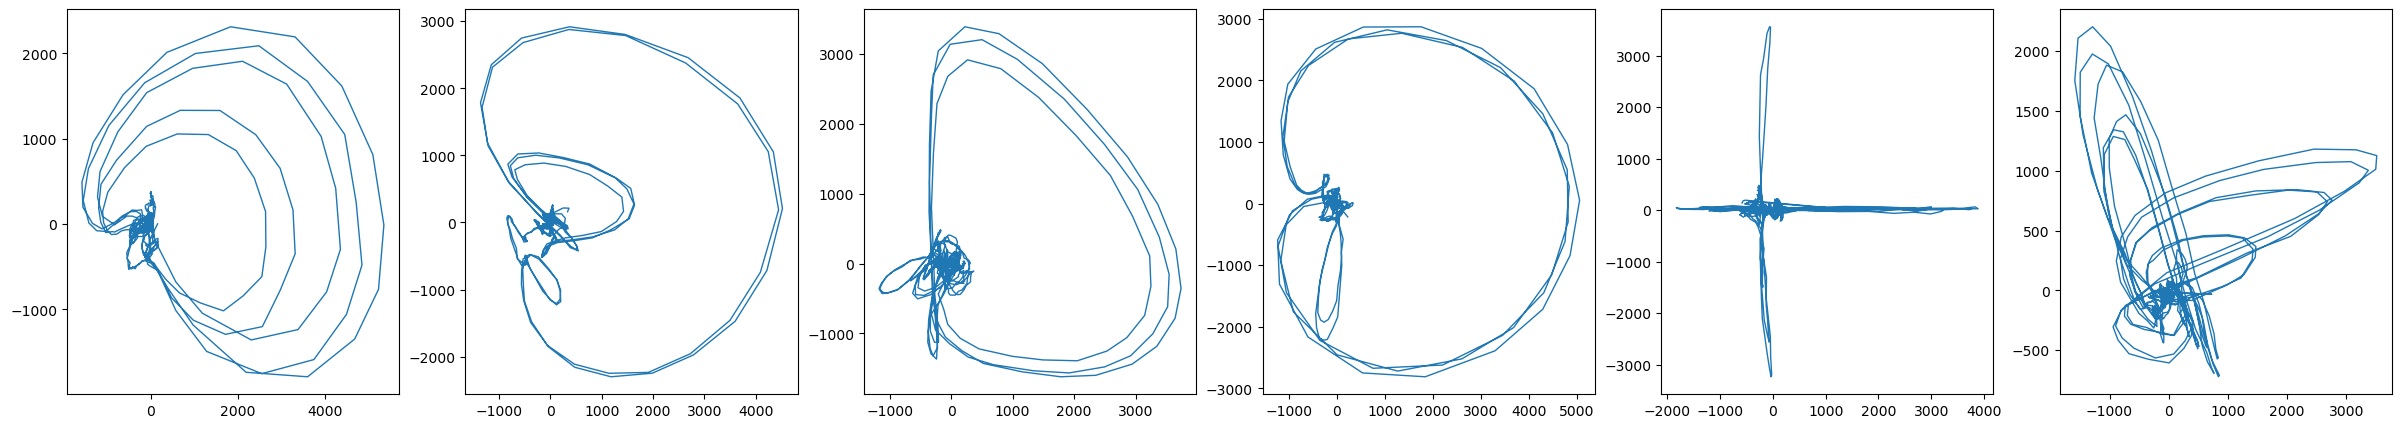

In [13]:
plt.figure(figsize=(5*unmixed.shape[1],5))
for i in range(unmixed.shape[1]):
    plt.subplot(1,unmixed.shape[1],i+1)
    x_pca = PCA(2).fit_transform(unmixed[:,i,:])
    plt.plot(x_pca[:,0],x_pca[:,1],linewidth=1)

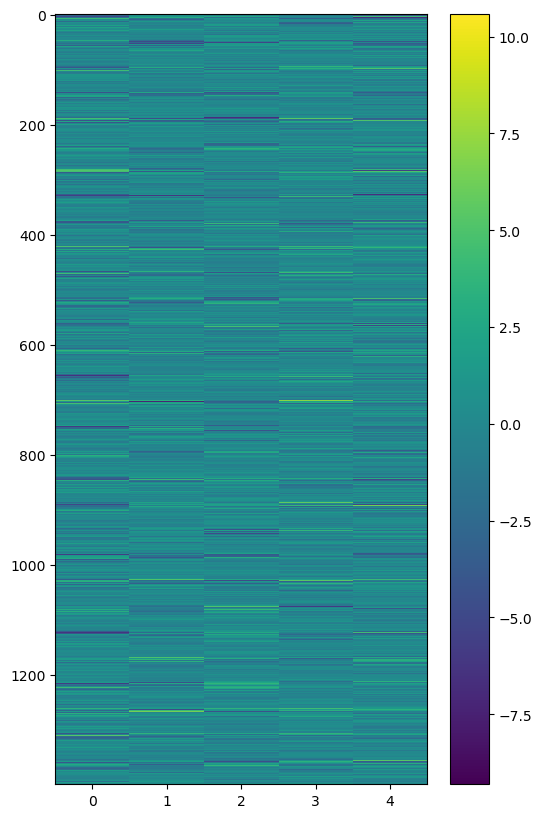

In [14]:

plt.figure(figsize=(6,10))
plt.imshow((trainer.model.get_weights()[:,0]),aspect="auto",interpolation="nearest")
plt.colorbar()

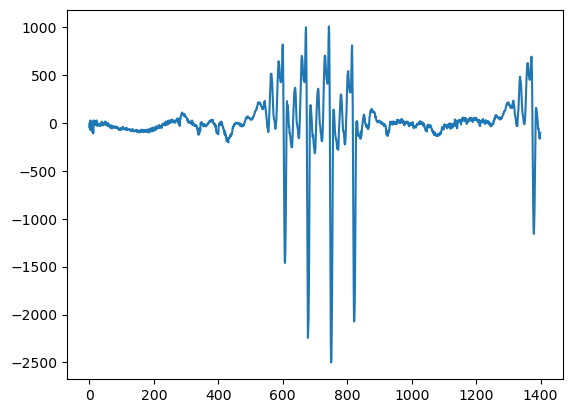

In [15]:
plt.plot(unmixed[:,0,0])

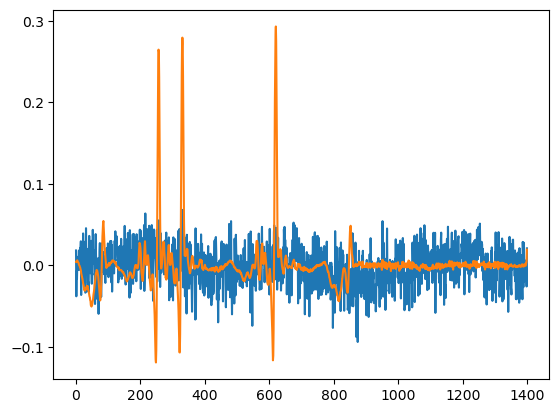

In [16]:
plt.plot(X[:,3169])
plt.plot(unmixed[:,3,0]/10000)

In [17]:
ma  = np.array([np.corrcoef(unmixed[:,3,[0]].T, X[:,[i]].T,) for i in range(X.shape[1])])

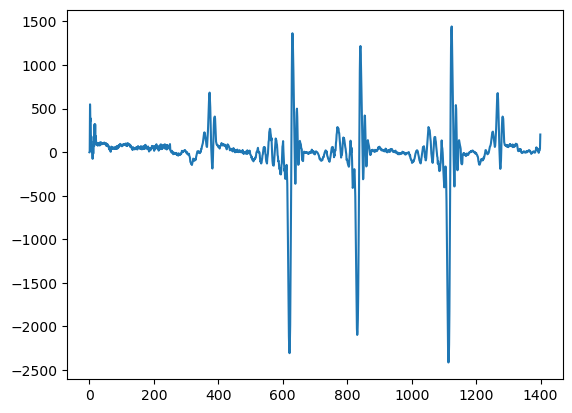

In [18]:
plt.plot(unmixed[:,2,0])

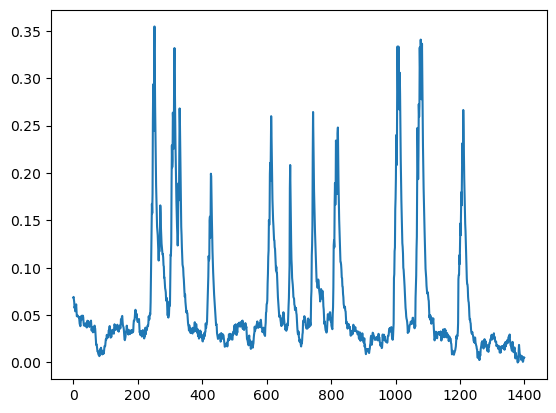

In [19]:
plt.plot(y)

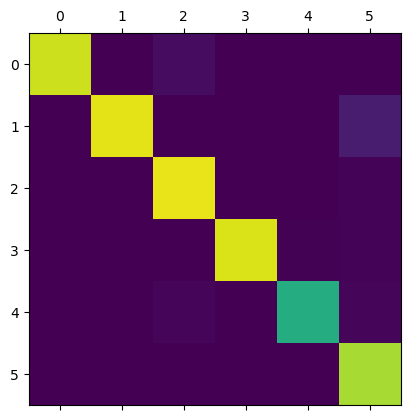

In [42]:
plt.matshow(CCM.PairwiseCCM().compute(np.transpose(unmixed,axes=(1,0,2)),np.transpose(unmixed,axes=(1,0,2)),1500,400,60,60,method="simplex",nbrs_num=15,).mean(axis=0),vmin=0,vmax=1)

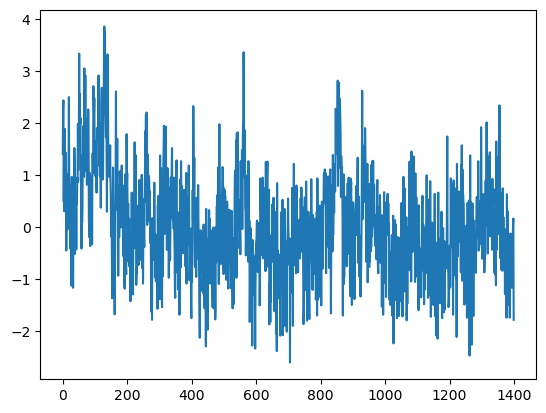

In [33]:
plt.plot((observables @ ppca.components_)[:,2])

In [459]:
trainer.model.get_weights()[:,0].shape

(1400, 5)

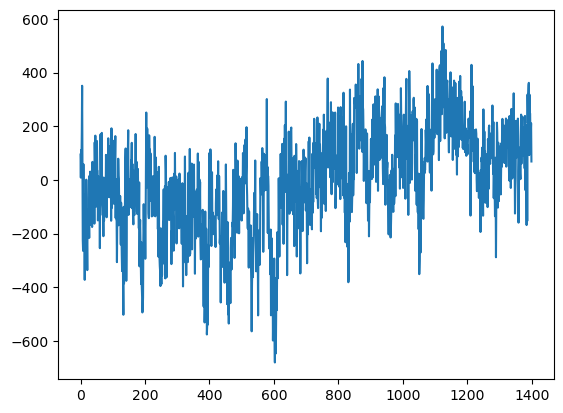

In [293]:
plt.plot((observables @ trainer.model.get_weights()[:,0])[:,0])

In [294]:
np.dot(observables, ppca.components_)


array([[ 1.97020612,  1.50972171,  2.95964393, ...,  0.59572408,
         1.62850056, -0.17960136],
       [ 2.25830872,  1.08436577,  4.07923477, ...,  0.73299855,
         1.80100443,  0.3680421 ],
       [ 1.88805483,  1.09731198,  3.47278486, ...,  0.65681   ,
         2.01555833,  1.44220777],
       ...,
       [-0.62518134, -0.73916912, -1.59589158, ..., -1.25923989,
        -0.59208878,  0.40003425],
       [-0.20921551,  0.09787853,  0.17732972, ..., -0.73408384,
        -2.1750759 , -1.81641012],
       [ 0.89235449,  0.0711883 , -0.7061726 , ..., -1.00758145,
        -1.62093113, -0.80028683]])

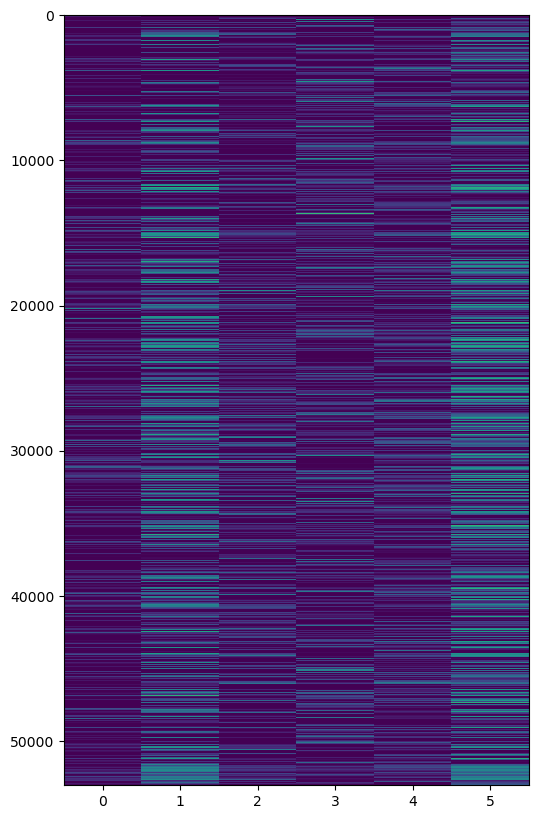

In [22]:
plt.figure(figsize=(6,10))
unmixed_xmap_X = CCM.PairwiseCCM().compute(np.transpose(unmixed,axes=(1,0,2)),X.T[:,:,None],15000,300,60,0,method="simplex",nbrs_num=15,).mean(axis=0)
plt.imshow(unmixed_xmap_X,vmin=0,vmax=1,aspect="auto",interpolation="nearest")

In [633]:
X.shape

(1400, 53051)

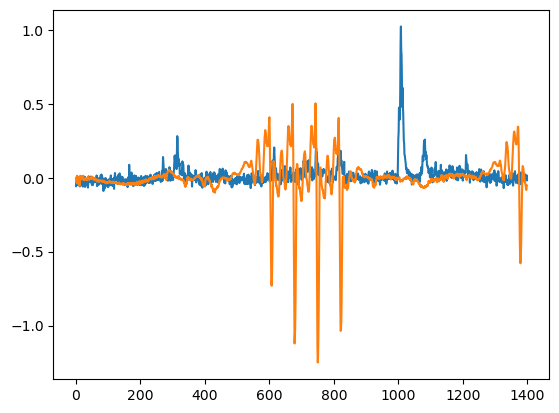

In [23]:
#plt.plot(X[:,20221])
plt.plot(X[:,13438])
plt.plot(unmixed[:,0,0]/2000)


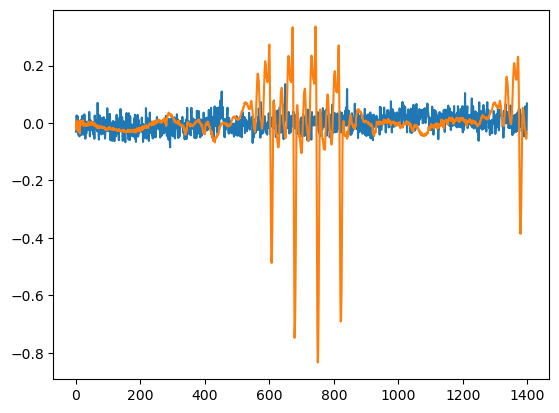

In [29]:
#plt.plot(X[:,20221])
plt.plot(X[:,4111])
plt.plot(unmixed[:,0,0]/3000)


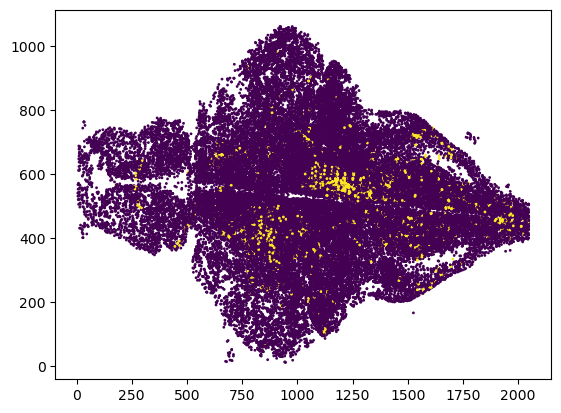

In [31]:

plt.scatter(pos[:,0],pos[:,1],s=1,c=unmixed_xmap_X[:,1]>0.5,vmax=1,vmin=0)

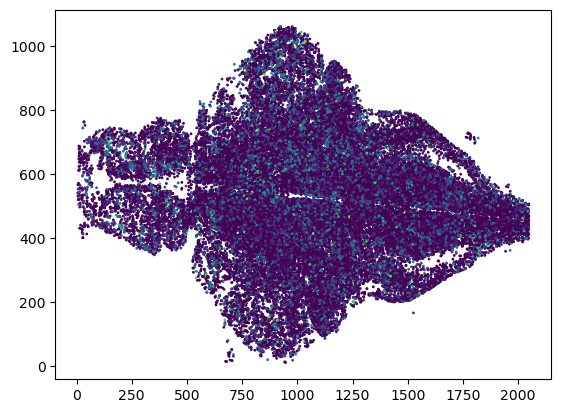

In [25]:

plt.scatter(pos[:,0],pos[:,1],s=1,c=trainer.model.get_weights()[:,0,0] @ ppca.components_,vmax=1,vmin=0)

In [26]:
import plotly.express as px
x_pca = PCA(3).fit_transform(unmixed[:,3,:])
fig = px.line_3d(x=x_pca[:,0], y=x_pca[:,1],z=x_pca[:,2],height=700)

fig.show()

In [28]:
[utils.calculate_rank_for_variance(unmixed[np.random.randint(0,unmixed.shape[0],5000),i],0.95) for i in range(unmixed.shape[1])]


[3, 4, 4, 3, 3, 4]

In [27]:
[utils.calculate_correlation_dimension(unmixed[np.random.randint(0,unmixed.shape[0],1000),i],device="cuda") for i in range(unmixed.shape[1])]

[2.123361825942993,
 2.2421271800994873,
 2.540843963623047,
 2.6995346546173096,
 1.9837863445281982,
 2.4503650665283203]